# Time Series Forecasting using Machine Learning models

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from green_city.utils import index2datetime
from green_city.regression import plot_ts, error_metrics, train_test_time_split, seasons, time_of_day

import warnings
warnings.filterwarnings('ignore')

RSEED = 42

In [4]:
write_data = False

In [5]:
building_nr = 5
column_to_predict = "net_load_kWh"

#document wide parameters that don't change in experiments
#for logging to mlflow server
global_params = {
    "building nr": building_nr,
    "predicted feature": column_to_predict,
    "resolution": "daily",
}

In [6]:
# Load data
df = pd.read_csv(f"../data/preprocessed/Building_{building_nr}.csv").astype({'datetime': 'datetime64'}).set_index('datetime')

In [7]:
# Add additional columns for time
df['hour'] = df.index.hour.astype('category')
df['month'] = df.index.month.astype('category')
df['year'] = df.index.year.astype('category')
df['holiday'] = df['holiday'].astype('category')
df['workday'] = df['workday'].astype('category')

df['season'] = df['month'].apply(seasons).astype('category')
df['time_of_day'] = df['hour'].apply(time_of_day).astype('category')
df['day_of_week'] = df.index.day_of_week.astype('category')

df['net_load_kW_lag1'] = df['net_load_kW'].shift(1)
df['net_load_kW_lag24'] = df['net_load_kW'].shift(24)

# # Exogenous variables for yearly, weekly and hourly seasonality
# df['year_sin365'] = np.sin(2 * np.pi * df.index.dayofyear / 365)
# df['year_cos365'] = np.cos(2 * np.pi * df.index.dayofyear / 365)
# df['year_sin365_2'] = np.sin(4 * np.pi * df.index.dayofyear / 365)
# df['year_cos365_2'] = np.cos(4 * np.pi * df.index.dayofyear / 365)
# df['week_sin365'] = np.sin(2 * np.pi * df.index.dayofweek/7)
# df['week_cos365'] = np.cos(2 * np.pi * df.index.dayofweek/7)
# df['week_sin365_2'] = np.sin(4 * np.pi * df.index.dayofweek/7)
# df['week_cos365_2'] = np.cos(4 * np.pi * df.index.dayofweek/7)
# df['hour_sin365'] = np.sin(2 * np.pi * df.index.hour/24)
# df['hour_cos365'] = np.cos(2 * np.pi * df.index.hour/24) 
# df['hour_sin365_2'] = np.sin(4 * np.pi * df.index.hour/24)
# df['hour_cos365_2'] = np.cos(4 * np.pi * df.index.hour/24) 

# Shift predicted weather values by 24hr
df['pred_24h_diffuse_solar_W_m2_shift'] = df['pred_24h_diffuse_solar_W_m2'].shift(periods=24)
df['pred_24h_direct_solar_W_m2_shift'] = df['pred_24h_direct_solar_W_m2'].shift(periods=24)
df['pred_24h_outdoor_temp_shift'] = df['pred_24h_outdoor_temp'].shift(periods=24)
df['pred_24h_outdoor_hum_shift'] = df['pred_24h_outdoor_hum'].shift(periods=24)
df = df.dropna()

In [36]:
def add_fourier_terms(df, year_k, week_k, day_k):
    """
    df: dataframe to add the fourier terms to 
    year_k: the number of Fourier terms the year period should have. Thus the model will be fit on 2*year_k terms (1 term for 
    sine and 1 for cosine)
    week_k: same as year_k but for weekly periods
    day_k:same as year_k but for daily periods
    """
    
    for k in range(1, year_k+1):
        # year has a period of 365.25 including the leap year
        df['year_sin'+str(k)] = np.sin(2 *k* np.pi * df.index.dayofyear/365.25) 
        df['year_cos'+str(k)] = np.cos(2 *k* np.pi * df.index.dayofyear/365.25)

    for k in range(1, week_k+1):
        
        # week has a period of 7
        df['week_sin'+str(k)] = np.sin(2 *k* np.pi * df.index.dayofweek/7)
        df['week_cos'+str(k)] = np.cos(2 *k* np.pi * df.index.dayofweek/7)


    for k in range(1, day_k+1):
        
        # day has period of 24
        df['hour_sin'+str(k)] = np.sin(2 *k* np.pi * df.index.hour/24)
        df['hour_cos'+str(k)] = np.cos(2 *k* np.pi * df.index.hour/24) 

In [ ]:
df(year_k=5, week_k=5, day_k=5)

## Random forest regression

We first train the model based on the measured weather data. We then use the trained model to forecast the net energy usage based on the 24h predicted weather data.

In [8]:
# Include weather features for random forest regression
features = ['outdoor_temp', 'outdoor_hum', 
            'diffuse_solar_W_m2', 'direct_solar_W_m2', 
            'time_of_day', 'season', 'holiday', 'workday',
            'net_load_kW_lag1', 'net_load_kW_lag24', 
            'year_sin365','year_cos365', 'year_sin365_2', 'year_cos365_2', 
            'week_sin365','week_cos365', 'week_sin365_2', 'week_cos365_2',
            'hour_sin365','hour_cos365','hour_sin365_2','hour_cos365_2']
dummy_features = ['time_of_day', 'season', 'holiday', 'workday']
target = 'net_load_kW'

# Do train-test split
X_train, y_train, X_test, y_test, df_train, df_test = train_test_time_split(
                                                        df, features, target, 
                                                        dummy_features)

In [9]:
# Create the model
rf = RandomForestRegressor(random_state=RSEED)

# Fit on training data
rf.fit(X_train, y_train)

# Predict train and test data
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

# Calculate and print error metrics
_ = error_metrics(y_train, y_pred_train, y_test, y_pred_test, title="Random Forest Regressor")

----------------------------------------
Random Forest Regressor
----------------------------------------
R2 (train): 0.98
R2 (test) : 0.824
MAE (test): 3.461
MSE (test): 21.734
RMSE(test): 4.662


### Run random search with cross validation to narrow down optimal hyperparameters

In [10]:
# Time series split for cross validation
tscv = TimeSeriesSplit(n_splits=3)

# Do a randomized search
rscv = RandomizedSearchCV(
                estimator=RandomForestRegressor(random_state=RSEED),
                param_distributions={
                "min_samples_split": [4, 5, 6, 7, 10],
                "min_samples_leaf": [10, 20, 50, 80, 100],
                "max_depth": [6, 7, 8, 9, 10],
                "n_estimators": [100, 150, 200]
                },
                cv=tscv, n_iter=20, verbose=2, n_jobs=-1)

# Fit train data
rf_search = rscv.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END max_depth=9, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   3.2s
[CV] END max_depth=8, min_samples_leaf=50, min_samples_split=6, n_estimators=200; total time=   5.0s
[CV] END max_depth=10, min_samples_leaf=20, min_samples_split=7, n_estimators=200; total time=   6.0s
[CV] END max_depth=9, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=   6.8s
[CV] END max_depth=9, min_samples_leaf=80, min_samples_split=7, n_estimators=200; total time=   4.4s
[CV] END max_depth=9, min_samples_leaf=10, min_samples_split=10, n_estimators=100; total time=  10.2s
[CV] END max_depth=8, min_samples_leaf=50, min_samples_split=6, n_estimators=200; total time=  10.5s
[CV] END max_depth=10, min_samples_leaf=20, min_samples_split=7, n_estimators=200; total time=  13.1s
[CV] END max_depth=6, min_samples_leaf=50, min_samples_split=10, n_estimators=200; total time=   4.7s
[CV] END max_depth=6, mi

In [11]:
print("Best model:", rf_search.best_params_)

rf_model = rf_search.best_estimator_
rf_params = rf_search.best_params_

y_pred_train = rf_model.predict(X_train)
y_pred_test = rf_model.predict(X_test)

df_train['random_forest'] = y_pred_train
df_test['random_forest'] = y_pred_test

_ = error_metrics(y_train, y_pred_train, y_test, y_pred_test, title="Random forest")

Best model: {'n_estimators': 150, 'min_samples_split': 7, 'min_samples_leaf': 10, 'max_depth': 9}
----------------------------------------
Random forest
----------------------------------------
R2 (train): 0.874
R2 (test) : 0.807
MAE (test): 3.615
MSE (test): 23.842
RMSE(test): 4.883


### Grid search to find the optimal hyperparameters

In [13]:
tscv = TimeSeriesSplit(n_splits=3)

estimator = RandomForestRegressor(random_state=RSEED)

gsc = GridSearchCV(
        estimator=estimator,
        param_grid={
                "min_samples_split": [4, 7, 10],
                "min_samples_leaf": [8, 10, 12],
                "max_depth": [7, 10],
                "n_estimators": [150, 200, 250]
                },
        cv=tscv, scoring='r2', verbose=2, n_jobs=-1)

grid_search = gsc.fit(X_train, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV] END max_depth=7, min_samples_leaf=8, min_samples_split=4, n_estimators=150; total time=   4.1s
[CV] END max_depth=7, min_samples_leaf=8, min_samples_split=4, n_estimators=200; total time=   5.7s
[CV] END max_depth=7, min_samples_leaf=8, min_samples_split=4, n_estimators=250; total time=   7.5s
[CV] END max_depth=7, min_samples_leaf=8, min_samples_split=4, n_estimators=150; total time=   8.8s
[CV] END max_depth=7, min_samples_leaf=8, min_samples_split=7, n_estimators=150; total time=   4.7s
[CV] END max_depth=7, min_samples_leaf=8, min_samples_split=4, n_estimators=200; total time=  11.8s
[CV] END max_depth=7, min_samples_leaf=8, min_samples_split=4, n_estimators=150; total time=  14.8s
[CV] END max_depth=7, min_samples_leaf=8, min_samples_split=4, n_estimators=250; total time=  15.9s
[CV] END max_depth=7, min_samples_leaf=8, min_samples_split=7, n_estimators=200; total time=   7.8s
[CV] END max_depth=7, min_samples_leaf

In [14]:
print(grid_search.best_params_)

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

df_train['random_forest'] = y_pred_train
df_test['random_forest'] = y_pred_test

_ = error_metrics(y_train, y_pred_train, y_test, y_pred_test, title="XGBRegressor")

{'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 250}
----------------------------------------
XGBRegressor
----------------------------------------
R2 (train): 0.888
R2 (test) : 0.814
MAE (test): 3.551
MSE (test): 23.051
RMSE(test): 4.801


In [15]:
# Using predicted weather to forecast net energy usage
features = ['pred_24h_outdoor_temp_shift', 'pred_24h_outdoor_hum_shift',
            'pred_24h_diffuse_solar_W_m2_shift','pred_24h_direct_solar_W_m2_shift', 
            'time_of_day', 'season', 'holiday', 'workday',
            'net_load_kW_lag1', 'net_load_kW_lag24', 
            'year_sin365','year_cos365', 'year_sin365_2', 'year_cos365_2', 
            'week_sin365','week_cos365', 'week_sin365_2', 'week_cos365_2',
            'hour_sin365','hour_cos365','hour_sin365_2','hour_cos365_2']
dummy_features = ['time_of_day', 'season', 'holiday', 'workday']
target = 'net_load_kW'

# Do train-test split
X_train, y_train, X_test, y_test, df_train, df_test = train_test_time_split(
                                                        df, features, target, 
                                                        dummy_features)

In [16]:
# Predict 
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

df_train['random_forest'] = y_pred_train
df_test['random_forest'] = y_pred_test

_ = error_metrics(y_train, y_pred_train, y_test, y_pred_test, title="Random forest")

----------------------------------------
Random forest
----------------------------------------
R2 (train): 0.873
R2 (test) : 0.81
MAE (test): 3.592
MSE (test): 23.466
RMSE(test): 4.844


Day: 2011-09-01 23:00:00, mae: 3.571, mse: 25.634, rmse: 5.063, r2: 0.662


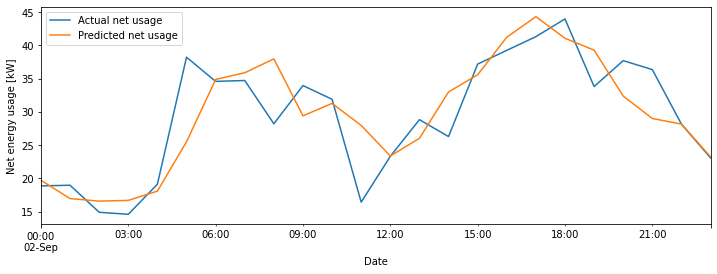

Day: 2011-10-20 23:00:00, mae: 3.817, mse: 20.979, rmse: 4.580, r2: 0.461


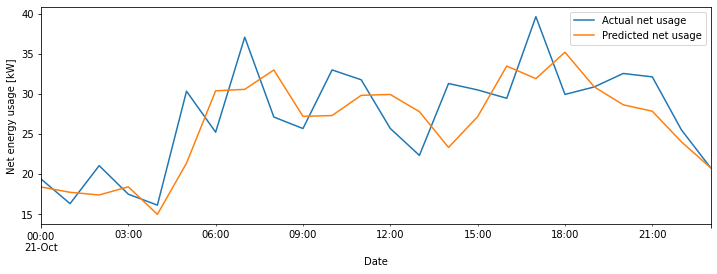

Day: 2011-01-09 06:00:00, mae: 4.324, mse: 50.424, rmse: 7.101, r2: -0.161


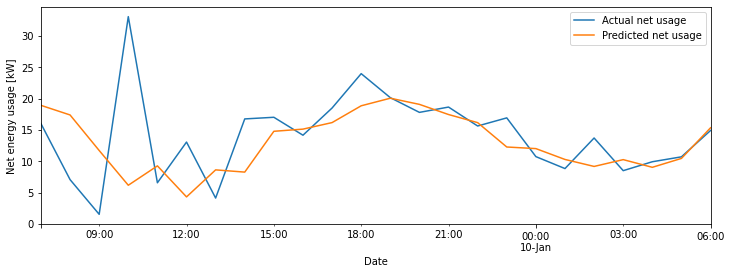

Day: 2011-10-22 21:00:00, mae: 3.540, mse: 18.468, rmse: 4.297, r2: 0.750


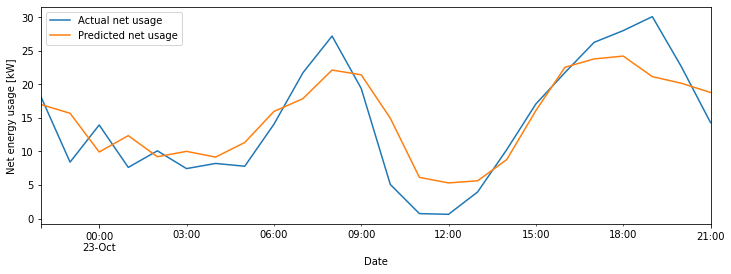

Day: 2011-06-21 03:00:00, mae: 5.038, mse: 43.653, rmse: 6.607, r2: 0.481


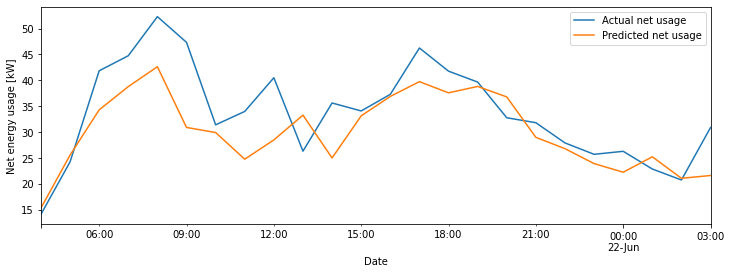

Day: 2011-07-08 02:00:00, mae: 3.808, mse: 23.487, rmse: 4.846, r2: 0.612


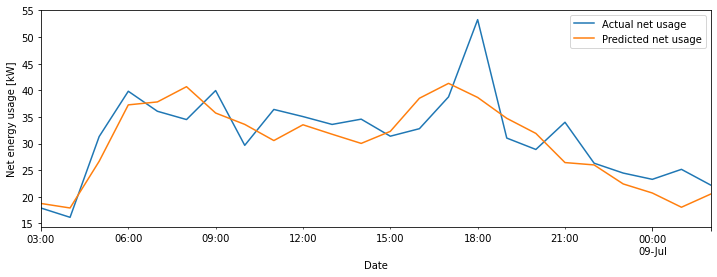

Day: 2011-08-19 00:00:00, mae: 2.516, mse: 12.462, rmse: 3.530, r2: 0.818


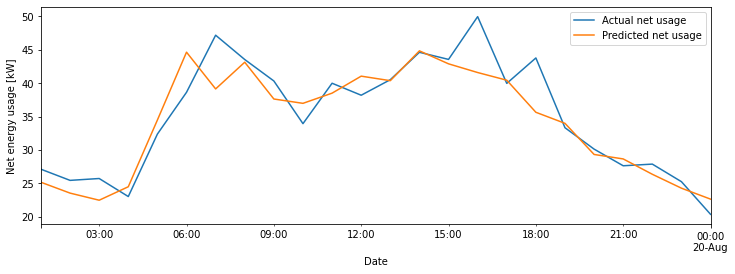

Day: 2011-04-15 07:00:00, mae: 5.241, mse: 35.506, rmse: 5.959, r2: 0.302


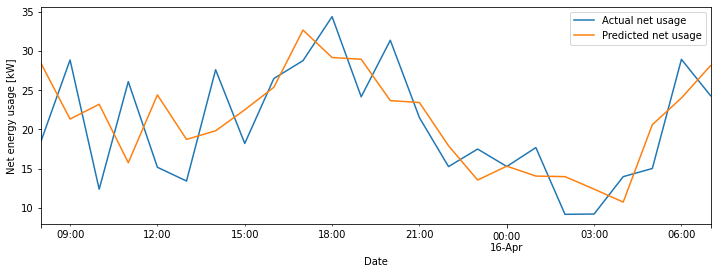

In [17]:
# Randomly chosen list of indices to forecast
pred_indices = [32135, 33311, 26478, 33357, 30387, 30794, 31800, 28783]

mae_list = []
mse_list = []
r2_list = []
forecasts = pd.DataFrame(columns=['prediction','run_id','id'])
for index in pred_indices:

  day = index2datetime(index)
  start_hour = day + pd.DateOffset(hours=1)
  end_hour = day + pd.DateOffset(hours=24)
  forecast_hours = pd.date_range(start=start_hour, end=end_hour, freq='H')
  y_pred = df_test['random_forest'][df_test.index.isin(forecast_hours)]
  y_test = df_test['net_load_kW'][df_test.index.isin(forecast_hours)]

  # Print error metrics
  mae = mean_absolute_error(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)
  print(f"Day: {day}, mae: {mae:.3f}, mse: {mse:.3f}, rmse: {np.sqrt(mse):.3f}, r2: {r2:.3f}")
  mae_list.append(mae)
  mse_list.append(mse)
  r2_list.append(r2)

  # Plot actual vs predicted net energy usage for each of the chosen days
  plot_ts(df_test['net_load_kW'][df_test.index.isin(forecast_hours)], 
          df_test['random_forest'][df_test.index.isin(forecast_hours)])

  if write_data:
    # ##########
    # # MLFLOW #
    # ##########
    # Starting the MLFlow run
    r = mlflow.start_run(run_name="linear_regression_time")
    print("run-uuid:", r.info.run_uuid)

    for k, v in global_params.items():
      mlflow.log_param(k, v)
      mlflow.log_param("model", "linear_regression_time")
      mlflow.log_param("datetime", day)
      mlflow.log_param("feature", "net_load_kW")
      mlflow.log_metric("mse", mse)
      mlflow.log_metric("mae", mae)
      mlflow.log_metric("r2_score", r2)
    mlflow.end_run()
    
    # DataFrame for writing to SQL database
    day_forecast = pd.DataFrame(columns=['prediction','run_id','id'])
    day_forecast['prediction'] = y_pred
    day_forecast['run_id'] = r.info.run_uuid
    day_forecast['id'] = np.arange(index+1,index+25)
    forecasts = pd.concat([forecasts, day_forecast], axis=0)

# Write to SQL DB
if write_data:
  forecasts = forecasts.set_index('id')
  forecasts.to_sql("forecast", con=db, if_exists="append")
  

In [18]:
print(f"Avg mae: {np.mean(mae_list):.3f}, Avg mse: {np.mean(mse_list):.3f}, Avg rmse: {np.sqrt(np.mean(mse_list)):.3f}, Avg r2: {np.mean(r2):.3f}")

Avg mae: 3.982, Avg mse: 28.827, Avg rmse: 5.369, Avg r2: 0.302


## XGBoost

### XGBoost excluding weather

In [23]:
# Exclude weather features
features = ['hour', 'month', 'holiday', 'workday',
            'net_load_kW_lag1', 'net_load_kW_lag24',
            'year_sin365','year_cos365', 'year_sin365_2', 'year_cos365_2', 
            'week_sin365','week_cos365', 'week_sin365_2', 'week_cos365_2',
            'hour_sin365','hour_cos365','hour_sin365_2','hour_cos365_2']
dummy_features = ['hour', 'month', 'holiday', 'workday']
target = 'net_load_kW'

# Do train-test split
X_train, y_train, X_test, y_test, df_train, df_test = train_test_time_split(
                                                        df, features, target, 
                                                        dummy_features)

In [24]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', random_state=RSEED)

xg_reg.fit(X_train, y_train)  # Fit training data

# predict on test-set
y_pred_train = xg_reg.predict(X_train)
y_pred_test = xg_reg.predict(X_test)

df_train['xgboost'] = y_pred_train
df_test['xgboost'] = y_pred_test

_ = error_metrics(y_train, y_pred_train, y_test, y_pred_test, title="XGBRegressor")

----------------------------------------
XGBRegressor
----------------------------------------
R2 (train): 0.881
R2 (test) : 0.564
MAE (test): 5.603
MSE (test): 53.938
RMSE(test): 7.344


Day: 2011-09-01 23:00:00, mae: 3.820, mse: 22.783, rmse: 4.773, r2: 0.700


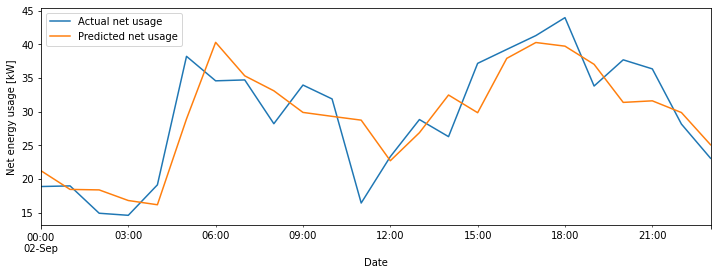

Day: 2011-10-20 23:00:00, mae: 5.480, mse: 42.902, rmse: 6.550, r2: -0.102


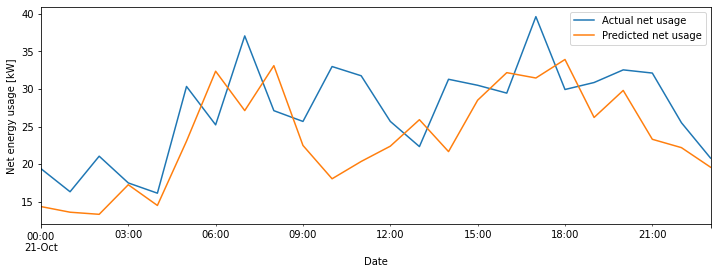

Day: 2011-01-09 06:00:00, mae: 4.591, mse: 39.047, rmse: 6.249, r2: 0.101


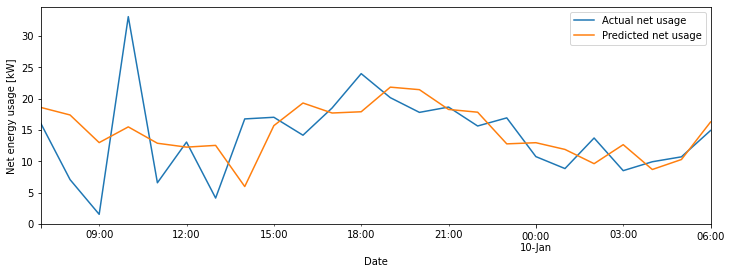

Day: 2011-10-22 21:00:00, mae: 4.232, mse: 28.032, rmse: 5.295, r2: 0.621


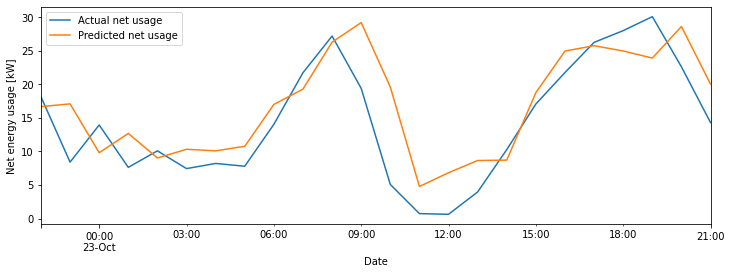

Day: 2011-06-21 03:00:00, mae: 4.417, mse: 30.213, rmse: 5.497, r2: 0.641


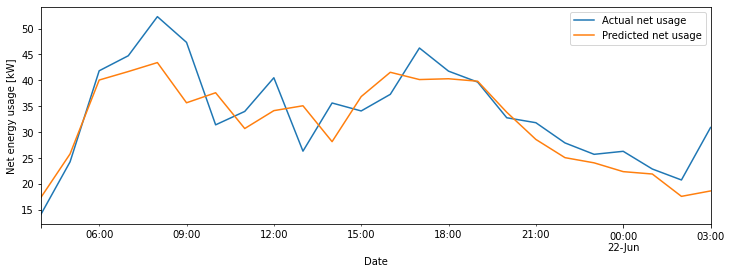

Day: 2011-07-08 02:00:00, mae: 3.753, mse: 27.478, rmse: 5.242, r2: 0.547


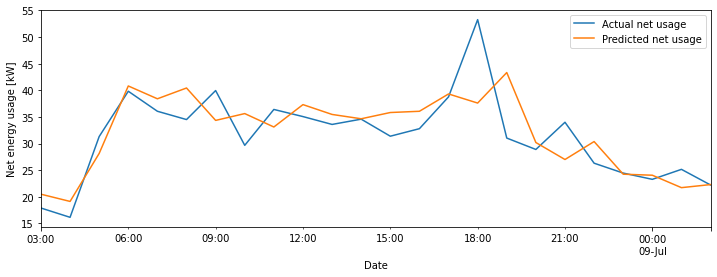

Day: 2011-08-19 00:00:00, mae: 3.290, mse: 19.903, rmse: 4.461, r2: 0.710


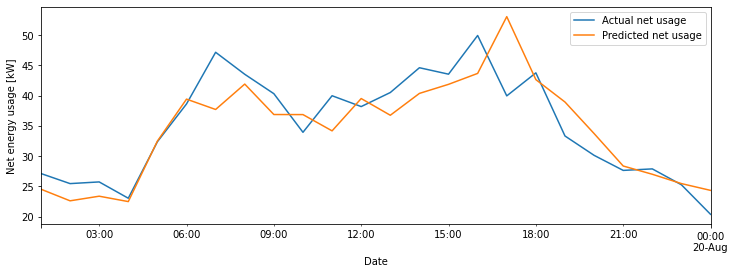

Day: 2011-04-15 07:00:00, mae: 4.779, mse: 32.892, rmse: 5.735, r2: 0.354


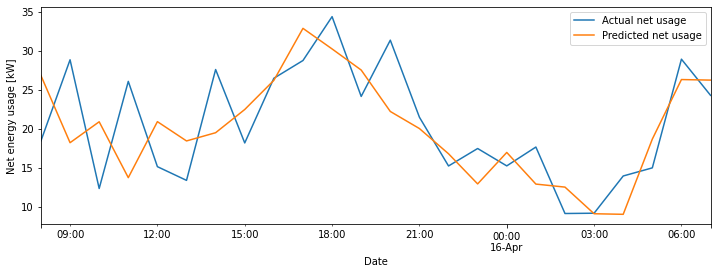

In [22]:
# Randomly chosen list of indices to forecast
pred_indices = [32135, 33311, 26478, 33357, 30387, 30794, 31800, 28783]

mae_list = []
mse_list = []
r2_list = []
forecasts = pd.DataFrame(columns=['prediction','run_id','id'])
for index in pred_indices:

  day = index2datetime(index)
  start_hour = day + pd.DateOffset(hours=1)
  end_hour = day + pd.DateOffset(hours=24)
  forecast_hours = pd.date_range(start=start_hour, end=end_hour, freq='H')
  y_pred = df_test['xgboost'][df_test.index.isin(forecast_hours)]
  y_test = df_test['net_load_kW'][df_test.index.isin(forecast_hours)]

  # Print error metrics
  mae = mean_absolute_error(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)
  print(f"Day: {day}, mae: {mae:.3f}, mse: {mse:.3f}, rmse: {np.sqrt(mse):.3f}, r2: {r2:.3f}")
  mae_list.append(mae)
  mse_list.append(mse)
  r2_list.append(r2)

  # Plot actual vs predicted net energy usage for each of the chosen days
  plot_ts(df_test['net_load_kW'][df_test.index.isin(forecast_hours)], 
          df_test['xgboost'][df_test.index.isin(forecast_hours)])

  if write_data:
    # ##########
    # # MLFLOW #
    # ##########
    # Starting the MLFlow run
    r = mlflow.start_run(run_name="poly_regression")
    print("run-uuid:", r.info.run_uuid)

    for k, v in global_params.items():
      mlflow.log_param(k, v)
      mlflow.log_param("model", "poly_regression")
      mlflow.log_param("datetime", day)
      mlflow.log_param("feature", "net_load_kW")
      mlflow.log_metric("mse", mse)
      mlflow.log_metric("mae", mae)
      mlflow.log_metric("r2_score", r2)
    mlflow.end_run()
    
    # DataFrame for writing to SQL database
    day_forecast = pd.DataFrame(columns=['prediction','run_id','id'])
    day_forecast['prediction'] = y_pred
    day_forecast['run_id'] = r.info.run_uuid
    day_forecast['id'] = np.arange(index+1,index+25)
    forecasts = pd.concat([forecasts, day_forecast], axis=0)

# Write to SQL DB
if write_data:
  forecasts = forecasts.set_index('id')
  forecasts.to_sql("forecast", con=db, if_exists="append")

In [178]:
print("Mean MAE:", np.mean(mae_list))
print("Mean MSE:", np.mean(mse_list))
print("Mean RMSE:", np.mean(np.sqrt(mse_list)))

Mean MAE: 3.6852776675224304
Mean MSE: 23.05494509394132
Mean RMSE: 4.733851417324893


### XGBoost including weather

In [25]:
# Include weather features 
features = ['outdoor_temp', 'outdoor_hum', 
            'diffuse_solar_W_m2', 'direct_solar_W_m2', 
            'hour', 'month', 'holiday', 'workday',
            'net_load_kW_lag1', 'net_load_kW_lag24',
            'year_sin365','year_cos365', 'year_sin365_2', 'year_cos365_2', 
            'week_sin365','week_cos365', 'week_sin365_2', 'week_cos365_2',
            'hour_sin365','hour_cos365','hour_sin365_2','hour_cos365_2']
dummy_features = ['hour', 'month', 'holiday', 'workday']
target = 'net_load_kW'

# Do train-test split
X_train, y_train, X_test, y_test, df_train, df_test = train_test_time_split(
                                                        df, features, target, 
                                                        dummy_features)

In [26]:
# xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', 
#                             learning_rate = 0.1, max_depth = 5, 
#                             n_estimators = 200, random_state=RSEED)

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', random_state=RSEED)

xg_reg.fit(X_train, y_train)  # Fit training data

# predict on test-set
y_pred_train = xg_reg.predict(X_train)
y_pred_test = xg_reg.predict(X_test)

df_train['xgboost'] = y_pred_train
df_test['xgboost'] = y_pred_test

_ = error_metrics(y_train, y_pred_train, y_test, y_pred_test, title="XGBRegressor")

----------------------------------------
XGBRegressor
----------------------------------------
R2 (train): 0.933
R2 (test) : 0.841
MAE (test): 3.298
MSE (test): 19.735
RMSE(test): 4.442


In [27]:
tscv = TimeSeriesSplit(n_splits=3)
gsc = GridSearchCV(
        estimator=xgb.XGBRegressor(),
        param_grid={"learning_rate": [0.01, 0.05, 0.10, 0.15],
                    "max_depth": [ 4, 5, 6, 7 ],
                    "n_estimators": [100, 150, 200],
                    },
        cv=tscv, scoring='r2', verbose=2, n_jobs=-1)

grid_search = gsc.fit(X_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=100; total time=   1.5s
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=150; total time=   2.1s
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=100; total time=   2.9s[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=200; total time=   2.9s

[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=   2.2s
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=100; total time=   4.7s
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=150; total time=   4.9s
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=200; total time=   6.1s
[CV] END ..learning_rate=0.01, max_depth=4, n_estimators=150; total time=   6.7s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=   4.4s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=150; total time=   3.3s
[CV] END ..learning_rate=0.01, max_depth=5, n_e

In [28]:
print(grid_search.best_params_)

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

df_train['xgboost'] = y_pred_train
df_test['xgboost'] = y_pred_test

_ = error_metrics(y_train, y_pred_train, y_test, y_pred_test, title="XGBRegressor")

{'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 200}
----------------------------------------
XGBRegressor
----------------------------------------
R2 (train): 0.922
R2 (test) : 0.844
MAE (test): 3.269
MSE (test): 19.335
RMSE(test): 4.397


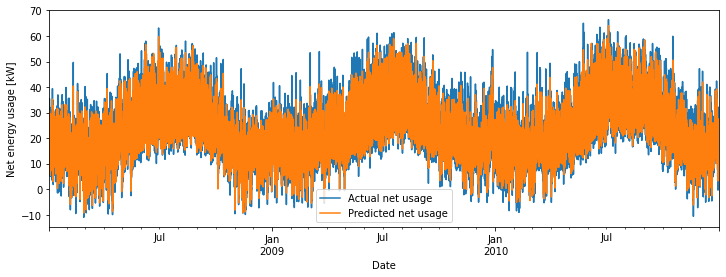

In [51]:
plot_ts(df_train['net_load_kW'], df_train['xgboost'])

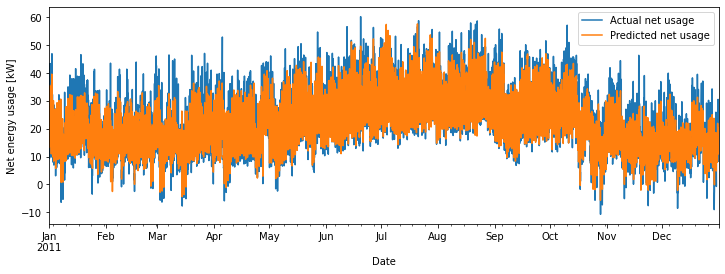

In [52]:
plot_ts(df_test['net_load_kW'], df_test['xgboost'])

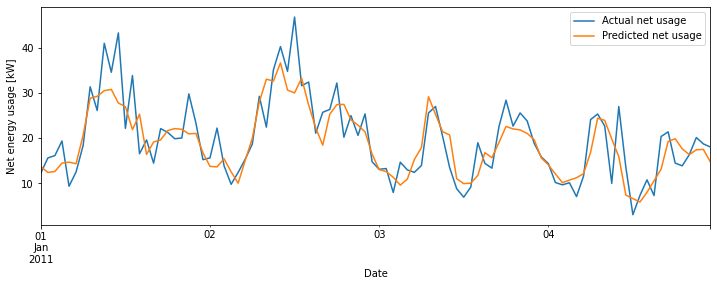

In [78]:
plot_ts(df_test['net_load_kW'].iloc[0:24*4], df_test['xgboost'].iloc[0:24*4])

### XGBoost using weather predictions

In [ ]:
# Using predicted weather to forecast net energy usage
features = ['pred_24h_outdoor_temp_shift', 'pred_24h_outdoor_hum_shift',
            'pred_24h_diffuse_solar_W_m2_shift','pred_24h_direct_solar_W_m2_shift', 
            'time_of_day', 'season', 'holiday', 'workday',
            'net_load_kW_lag1', 'net_load_kW_lag24', 
            'year_sin365','year_cos365', 'year_sin365_2', 'year_cos365_2', 
            'week_sin365','week_cos365', 'week_sin365_2', 'week_cos365_2',
            'hour_sin365','hour_cos365','hour_sin365_2','hour_cos365_2']
dummy_features = ['time_of_day', 'season', 'holiday', 'workday']
target = 'net_load_kW'

# Do train-test split
X_train, y_train, X_test, y_test, df_train, df_test = train_test_time_split(
                                                        df, features, target, 
                                                        dummy_features)

In [30]:
# Forecast using 24h weather predictions 
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

df_train['xgboost'] = y_pred_train
df_test['xgboost'] = y_pred_test

_ = error_metrics(y_train, y_pred_train, y_test, y_pred_test, title="Random forest")

----------------------------------------
Random forest
----------------------------------------
R2 (train): 0.922
R2 (test) : 0.844
MAE (test): 3.269
MSE (test): 19.335
RMSE(test): 4.397


Day: 2011-09-01 23:00:00, mae: 3.467, mse: 22.394, rmse: 4.732, r2: 0.705


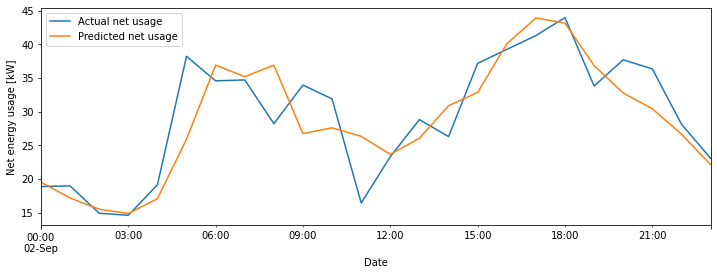

Day: 2011-10-20 23:00:00, mae: 3.648, mse: 21.108, rmse: 4.594, r2: 0.458


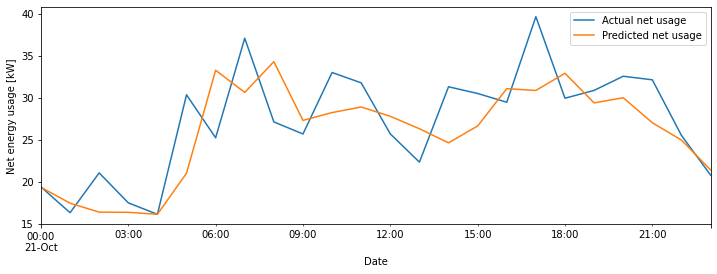

Day: 2011-01-09 06:00:00, mae: 3.870, mse: 33.746, rmse: 5.809, r2: 0.223


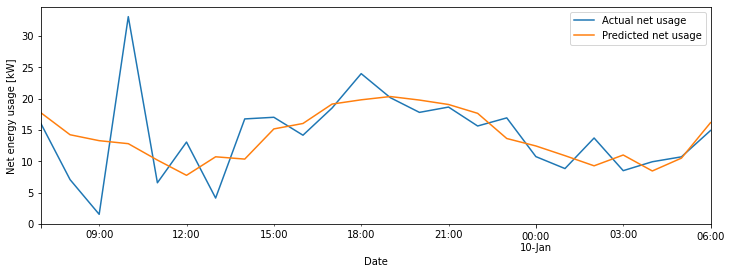

Day: 2011-10-22 21:00:00, mae: 2.632, mse: 10.255, rmse: 3.202, r2: 0.861


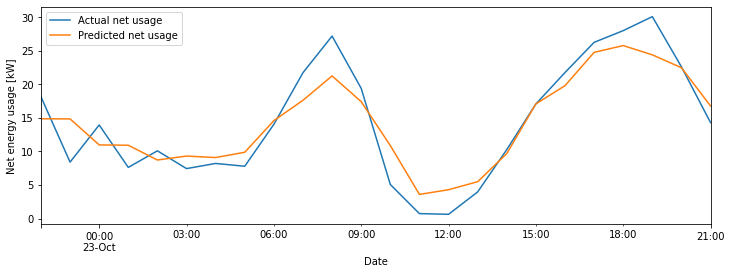

Day: 2011-06-21 03:00:00, mae: 4.765, mse: 42.052, rmse: 6.485, r2: 0.500


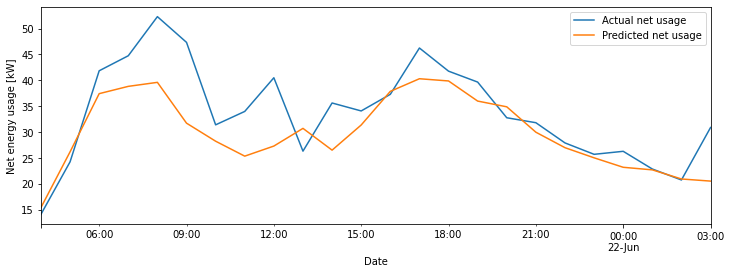

Day: 2011-07-08 02:00:00, mae: 3.850, mse: 22.595, rmse: 4.753, r2: 0.627


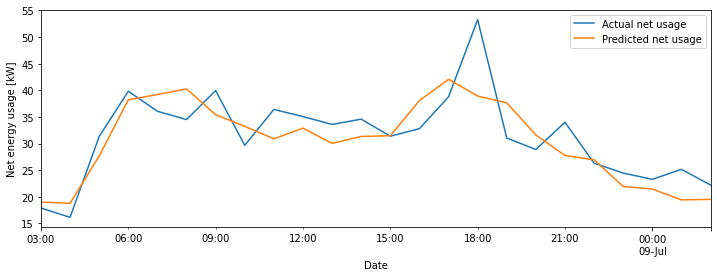

Day: 2011-08-19 00:00:00, mae: 2.325, mse: 9.622, rmse: 3.102, r2: 0.860


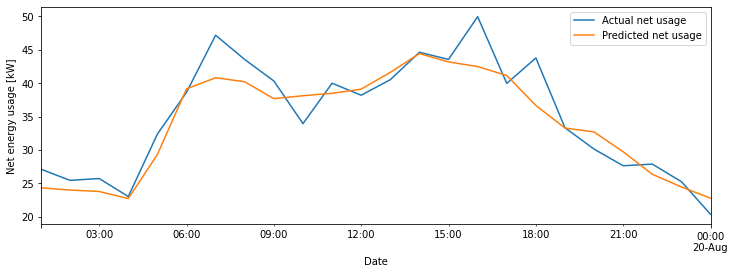

Day: 2011-04-15 07:00:00, mae: 4.277, mse: 24.802, rmse: 4.980, r2: 0.513


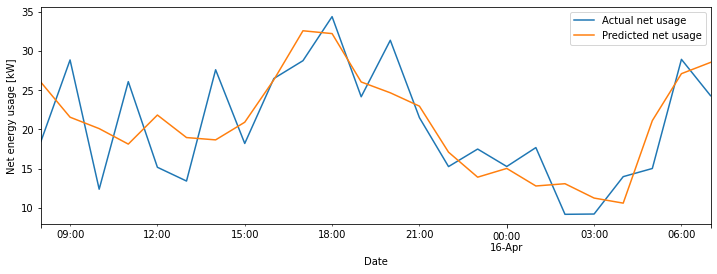

In [34]:
log_data(df_test, "xgboost", write_data)

# # Randomly chosen list of indices to forecast
# pred_indices = [32135, 33311, 26478, 33357, 30387, 30794, 31800, 28783]

# mae_list = []
# mse_list = []
# r2_list = []
# forecasts = pd.DataFrame(columns=['prediction','run_id','id'])
# for index in pred_indices:

#   day = index2datetime(index)

#   start_hour = day + pd.DateOffset(hours=1)
#   end_hour = day + pd.DateOffset(hours=24)
#   forecast_hours = pd.date_range(start=start_hour, end=end_hour, freq='H')
#   y_pred = df_test['xgboost'][df_test.index.isin(forecast_hours)]
#   y_test = df_test['net_load_kW'][df_test.index.isin(forecast_hours)]

#   # Plot actual vs predicted net energy usage for each of the chosen days
#   plot_ts(df_test['net_load_kW'][df_test.index.isin(forecast_hours)], df_test['xgboost'][df_test.index.isin(forecast_hours)])

#   mae = mean_absolute_error(y_test, y_pred)
#   mse = mean_squared_error(y_test, y_pred)
#   r2 = r2_score(y_test, y_pred)
#   print(f"Mean Absolute Error (Linear regression) = {mae.round(3)}")
#   print(f"Mean Squared Error (Linear regression) = {mse.round(3)}")
#   print(f"Root Mean Squared Error (Linear regression) = {np.sqrt(mse).round(3)}")
#   print(f"R2 score (Linear regression) = {r2.round(3)}")
#   print("---------------------------------------------")

#   mae_list.append(mae)
#   mse_list.append(mse)
#   r2_list.append(r2)

#   if write_data:
    
#     # ##########
#     # # MLFLOW #
#     # ##########
#     # Starting the MLFlow run
#     r = mlflow.start_run(run_name="poly_regression")
#     print("run-uuid:", r.info.run_uuid)

#     for k, v in global_params.items():
#       mlflow.log_param(k, v)
#       mlflow.log_param("model", "poly_regression")
#       mlflow.log_param("datetime", day)
#       mlflow.log_param("feature", "net_load_kW")
#       mlflow.log_metric("mse", mse)
#       mlflow.log_metric("mae", mae)
#       mlflow.log_metric("r2_score", r2)
#     mlflow.end_run()
    
#     # DataFrame for writing to SQL database
#     day_forecast = pd.DataFrame(columns=['prediction','run_id','id'])
#     day_forecast['prediction'] = y_pred
#     day_forecast['run_id'] = r.info.run_uuid
#     day_forecast['id'] = np.arange(index+1,index+25)
#     forecasts = pd.concat([forecasts, day_forecast], axis=0)

# # Write to SQL DB
# if write_data:
#   forecasts = forecasts.set_index('id')
#   forecasts.to_sql("forecast", con=db, if_exists="append")
  

In [33]:
def log_data(df_test, run_name, write_data):
      
  # Randomly chosen list of indices to forecast
  pred_indices = [32135, 33311, 26478, 33357, 30387, 30794, 31800, 28783]

  mae_list = []
  mse_list = []
  r2_list = []
  forecasts = pd.DataFrame(columns=['prediction','run_id','id'])
  for index in pred_indices:

    day = index2datetime(index)

    start_hour = day + pd.DateOffset(hours=1)
    end_hour = day + pd.DateOffset(hours=24)
    forecast_hours = pd.date_range(start=start_hour, end=end_hour, freq='H')
    y_pred = df_test[run_name][df_test.index.isin(forecast_hours)]
    y_test = df_test['net_load_kW'][df_test.index.isin(forecast_hours)]

    # Print error metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Day: {day}, mae: {mae:.3f}, mse: {mse:.3f}, rmse: {np.sqrt(mse):.3f}, r2: {r2:.3f}")
    mae_list.append(mae)
    mse_list.append(mse)
    r2_list.append(r2)

    # Plot actual vs predicted net energy usage for each of the chosen days
    plot_ts(df_test['net_load_kW'][df_test.index.isin(forecast_hours)], 
           df_test['xgboost'][df_test.index.isin(forecast_hours)])

    if write_data:

      # Starting the MLFlow run
      r = mlflow.start_run(run_name=run_name)
      print("run-uuid:", r.info.run_uuid)

      for k, v in global_params.items():
        mlflow.log_param(k, v)
        mlflow.log_param("model", run_name)
        mlflow.log_param("datetime", day)
        mlflow.log_param("feature", "net_load_kW")
        mlflow.log_metric("mse", mse)
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("r2_score", r2)
      mlflow.end_run()
    
      # DataFrame for writing to SQL database
      day_forecast = pd.DataFrame(columns=['prediction','run_id','id'])
      day_forecast['prediction'] = y_pred
      day_forecast['run_id'] = r.info.run_uuid
      day_forecast['id'] = np.arange(index+1,index+25)
      forecasts = pd.concat([forecasts, day_forecast], axis=0)

  # Write to SQL DB
  if write_data:
    forecasts = forecasts.set_index('id')
    forecasts.to_sql("forecast", con=db, if_exists="append")

In [35]:
print(np.mean(mae_list))
print(np.mean(mse_list))
print(np.mean(np.sqrt(mse_list)))

3.604207947174708
23.321594781075625
4.707268554525013
